# Regresión para el CSV tips.csv

In [24]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from joblib import dump, load

## 1. Carga del dataset

In [25]:
df = pd.read_csv('./tips.csv')
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


Como se puede apreciar tiene las siguientes columnas:

- **total_bill**: Hace referencia al coste total de la cuenta.
- **tip**: Variable decimal.
- **sex**: Variable categórica (Male/Female).
- **smoke**: Variable booleana.
- **day**: Variable categórica (Sat/Sun/Thur/Fri).
- **time**: Variable categórica (Dinner/Lunch)
- **size**: Variable numerica.

In [26]:
## Tratamiento de los datos:
## Se añaden dos columnas más para poder analizar si guarda relación con otras columnas
df['day_int'] = df['day'].apply(lambda x: ["Mon", "Tue", "Wen", "Thur", "Fri", "Sat", "Sun"].index(x))
df['time_int'] = df['time'].apply(lambda x: ["Lunch", "Dinner"].index(x))
df['datetime'] = df['day_int'] + (df['time_int'] / 10)
df2=df.dropna(axis=1) ## Borra las columnas que tiene algún valor nulo
df

,total_bill,tip,sex,smoker,day,time,size,day_int,time_int,datetime
0,16.99,1.01,Female,No,Sun,Dinner,2,6,1,6.1
1,10.34,1.66,Male,No,Sun,Dinner,3,6,1,6.1
2,21.01,3.50,Male,No,Sun,Dinner,3,6,1,6.1
3,23.68,3.31,Male,No,Sun,Dinner,2,6,1,6.1
4,24.59,3.61,Female,No,Sun,Dinner,4,6,1,6.1
...,...,...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,5,1,5.1
240,27.18,2.00,Female,Yes,Sat,Dinner,2,5,1,5.1
241,22.67,2.00,Male,Yes,Sat,Dinner,2,5,1,5.1
242,17.82,1.75,Male,No,Sat,Dinner,2,5,1,5.1


## 2. Visualización

[Text(0.5, 1.0, 'Pedidos por día de la semana')]

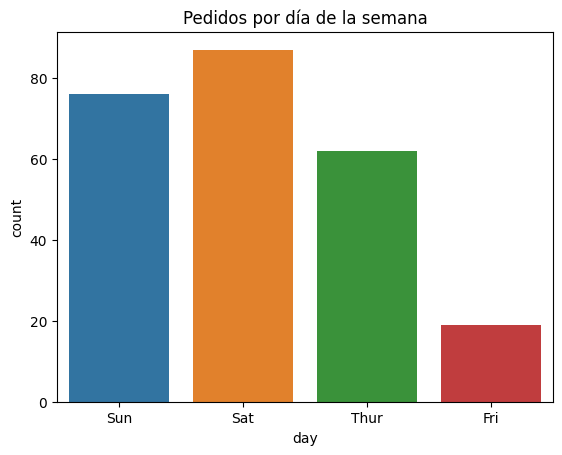

In [27]:
sns.countplot(data=df, x='day').set(title='Pedidos por día de la semana')

/home/martin/Projects/edix/tips/.env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


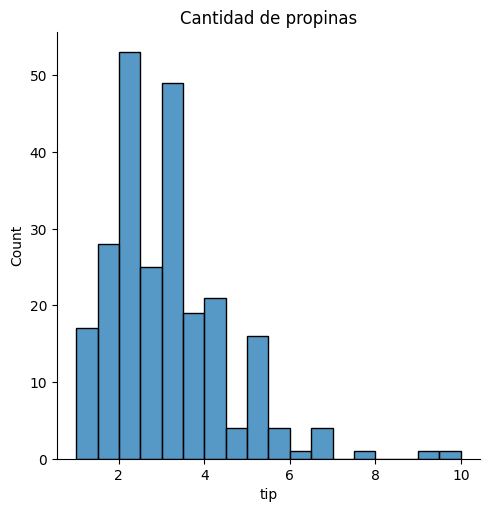

In [28]:
sns.displot(data=df, x='tip').set(title='Cantidad de propinas')
## Se puede apreciar que hay más pripinas de cantidades pequeñas

[Text(0.5, 1.0, 'Pedidos por turno')]

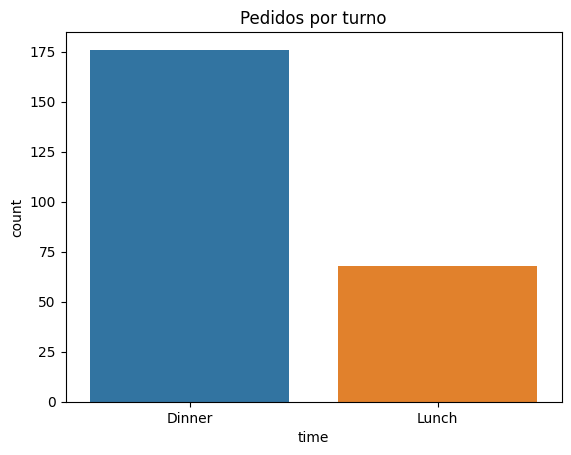

In [29]:
sns.countplot(data=df, x='time').set(title='Pedidos por turno')
## Se puede apreciar que hay más pedidos en el turno de la cena

/home/martin/Projects/edix/tips/.env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


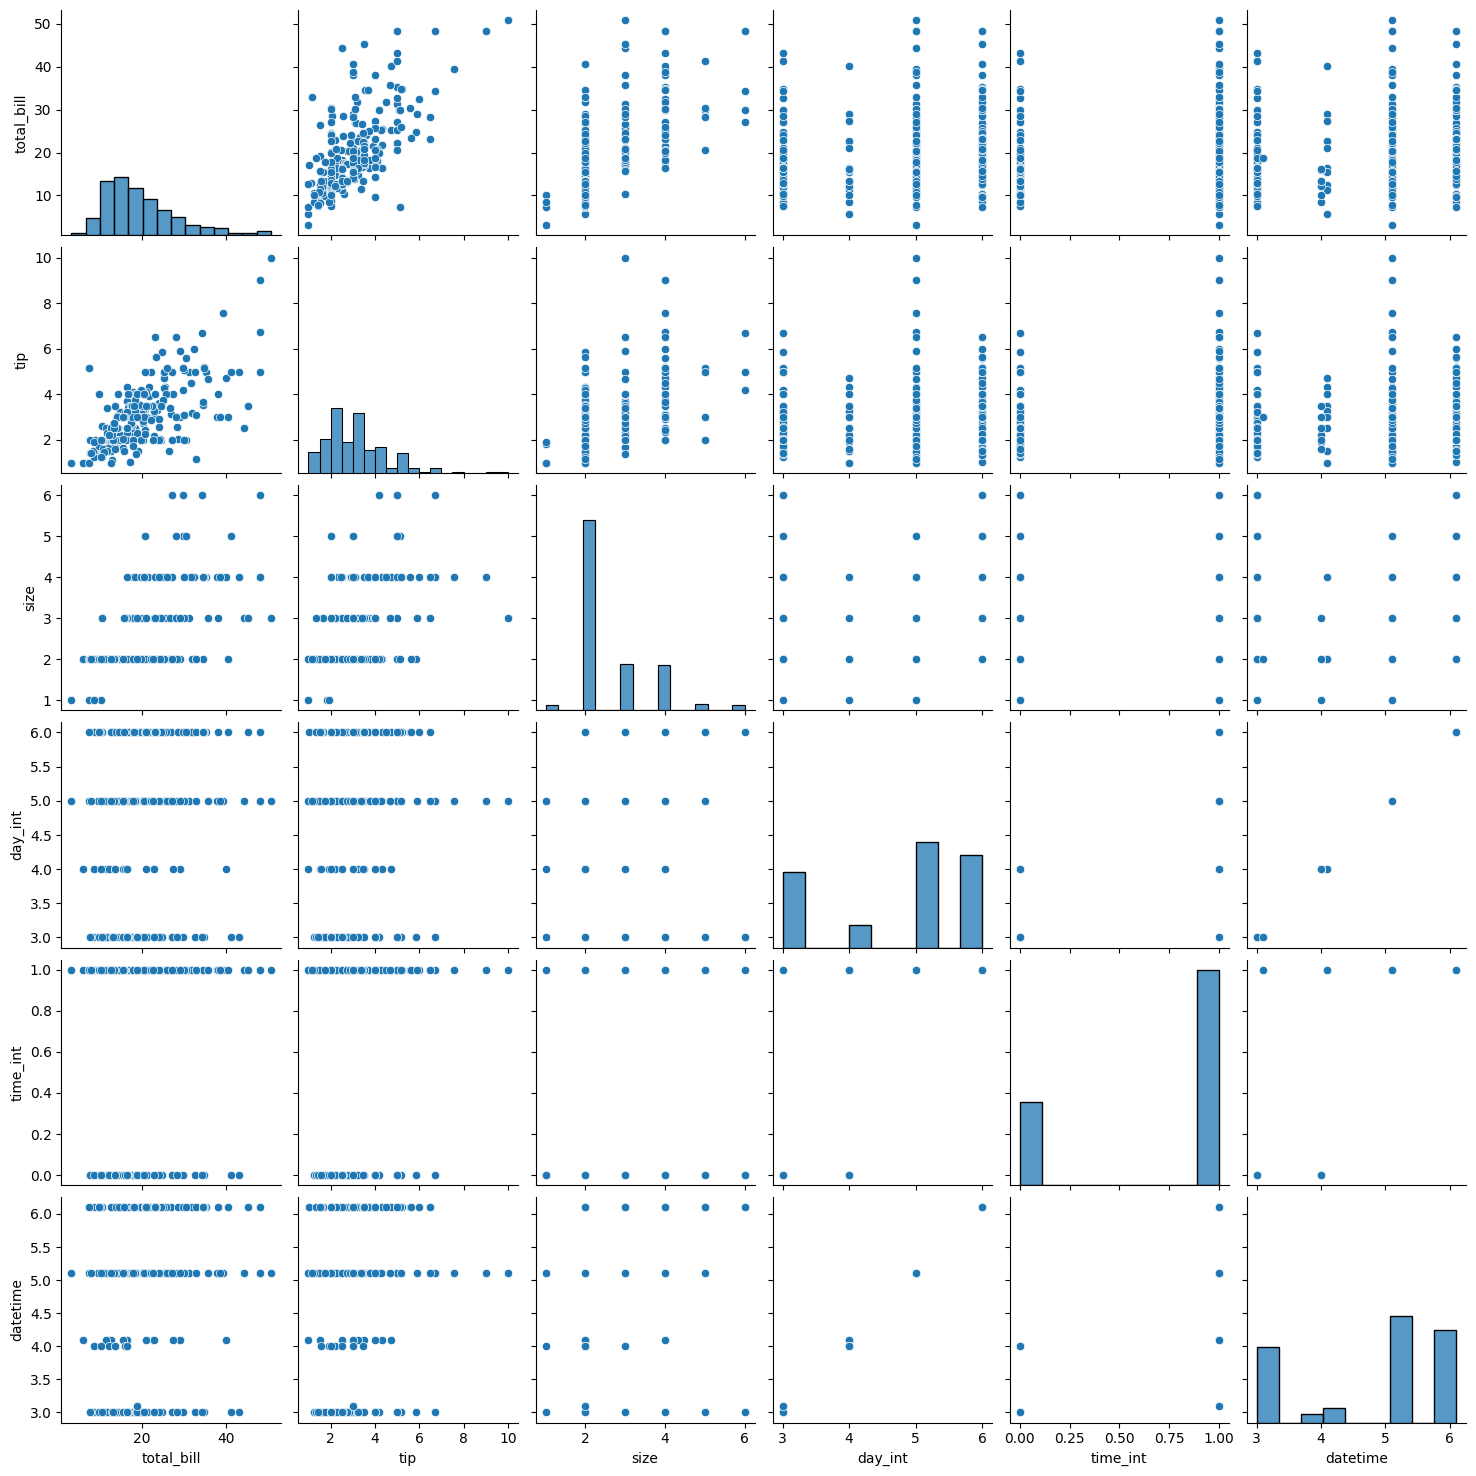

In [30]:
sns.pairplot(df)
## A simple vista en la siguiente gráfica se puede apreciar que las columnas que pueden tener más relación son total_bill y tip

/home/martin/Projects/edix/tips/.env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


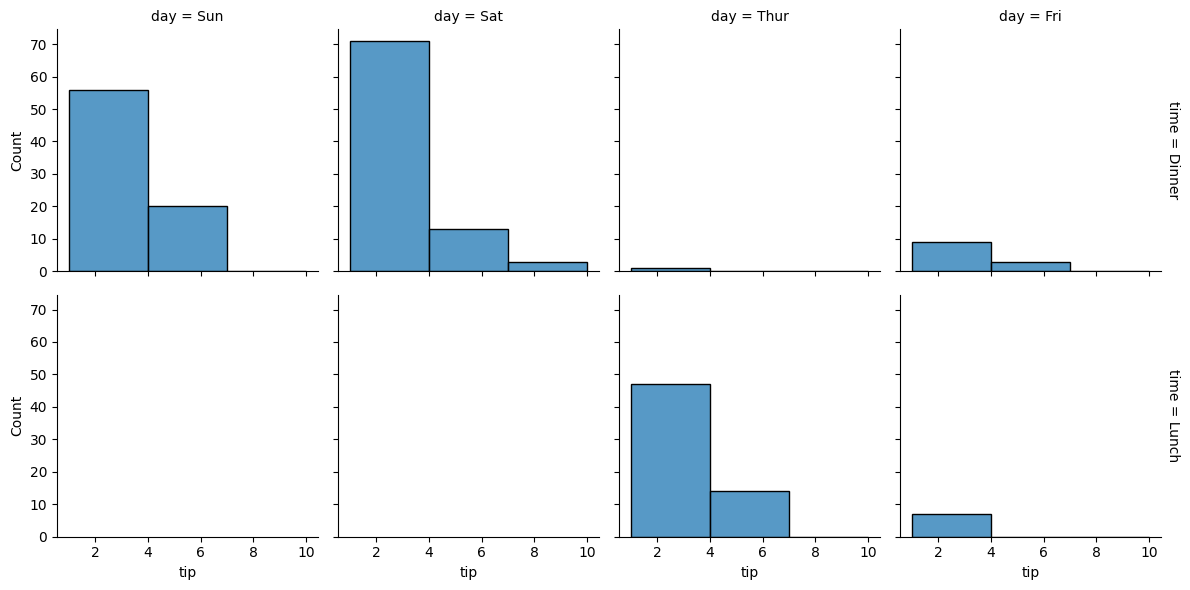

In [31]:
sns.displot(
    df, x="tip", col="day", row="time",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

/home/martin/Projects/edix/tips/.env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


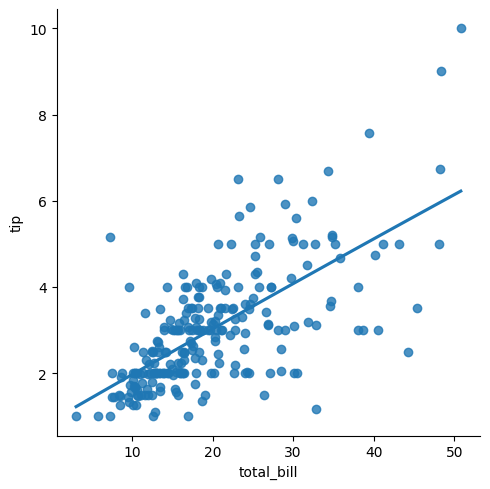

In [32]:
sns.lmplot(x ="total_bill", y ="tip", data = df, order = 2, ci = None)

<Axes: >

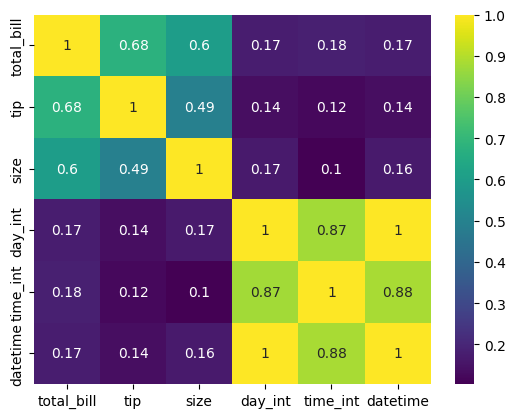

In [33]:
df_corr = df.corr(numeric_only=True)
sns.heatmap(df_corr, annot=True, cmap='viridis')

### Conclusiones

Como se puede apreciar, las propiedades que tienen una mayor relación son **tip**, **total_bill** y **size** por lo que van a ser estas las que tengan mayor influencia en la regresión

## 3. Regresión

In [34]:
df_results = pd.DataFrame(columns=['model_name', 'mae', 'mse', 'rmse', "score", "outlayers_deleted"])

def drop_outliers(df):
    df_copy = df.copy()

    for column in df_copy.columns:
        if df_copy[column].dtype == 'object':
            continue

        Q1 = df_copy[column].quantile(0.25)
        Q3 = df_copy[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        filter = (df_copy[column] >= lower_limit) & (df_copy[column] <= upper_limit)
        df_copy = df_copy[filter]

    return df_copy


# Esta función va a ser la que se utilice para probar diferentes escenarios, pero sin tener que duplicar código

def make_prediction(model_name, df, x_columns, y_column, delete_outliers= False):

    if delete_outliers:
        df = drop_outliers(df)

    X = df[x_columns]
    y = df[y_column]

    
    ## Split of the values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    ## Graphs
    sns.scatterplot(x=X_test['total_bill'], y=y_test)
    sns.lineplot(x=X_test['total_bill'], y=y_pred, c='r', label='Predicciones')


    ## Results
    mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
    rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)
    score = model.score(X_test, y_test)

    ## Data set results
    df_results.loc[df_results.shape[0]] = {
        "model_name": model_name,
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "score": score,
        "outlayers_deleted": delete_outliers
    }

    return model # Retorna el modelo para poder hacer predicciones con datos customizados


### 3.1 Regresión Simple (total_bill vs tip)

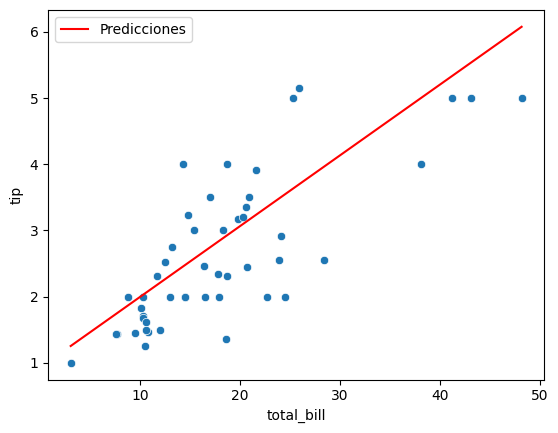

In [35]:
simple_model = make_prediction(
    model_name="Regresión Simple (total_bill vs tip)", 
    df=df, 
    x_columns=['total_bill'], 
    y_column='tip', 
)

### 3.2 Regresión Simple (total_bill vs tip) Without outliers

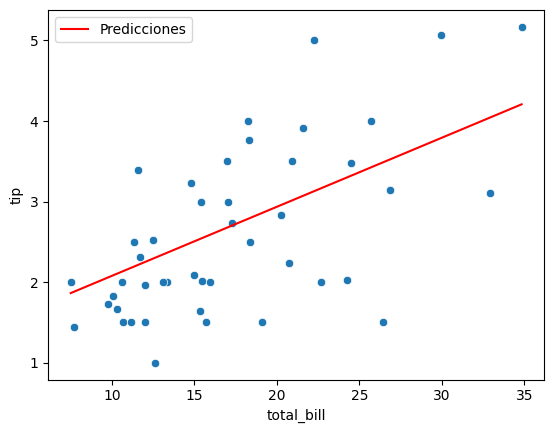

In [36]:
simple_model = make_prediction(
    model_name="Regresión Simple (total_bill vs tip)", 
    df=df, 
    x_columns=['total_bill'], 
    y_column='tip',
    delete_outliers=True
)

### 3.3 Regresión Múltiple (2 variables vs Tip)

LinearRegression()

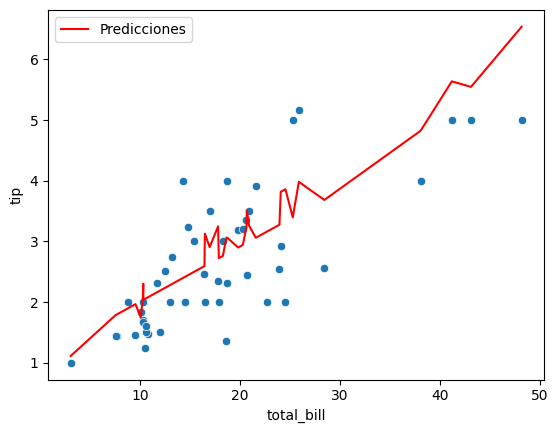

In [37]:
make_prediction(
    model_name="Regresión Múltiple (total_bill & size vs tip)", 
    df=df, 
    x_columns=['total_bill', 'size'], 
    y_column='tip'
)

### 3.4 Regresión Múltiple (2 variables vs Tip) Without outliers

LinearRegression()

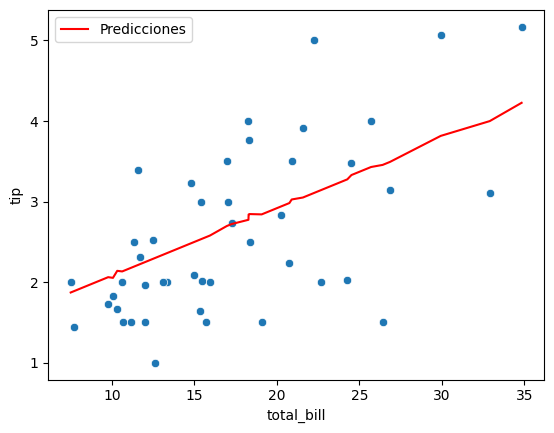

In [38]:
make_prediction(
    model_name="Regresión Múltiple (total_bill & size vs tip)", 
    df=df, 
    x_columns=['total_bill', 'size'], 
    y_column='tip',
    delete_outliers=True
)

### 3.4 Regresión Múltiple (3 variables vs Tip)

LinearRegression()

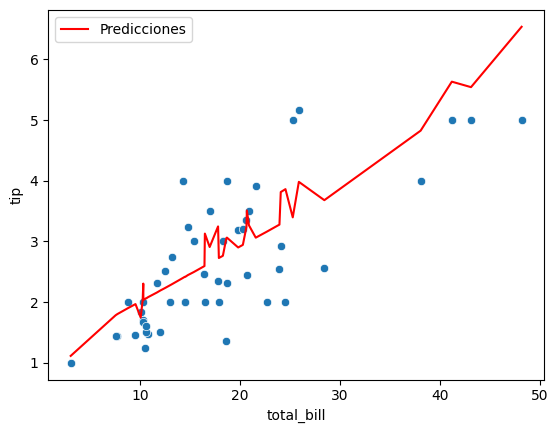

In [39]:
make_prediction(
    model_name="Regresión Múltiple (total_bill, size, datetime  vs tip)",  
    df=df, 
    x_columns=['total_bill', 'size', 'datetime'], 
    y_column='tip'
)

### 3.5 Regresión Múltiple (3 variables vs Tip) Without outliers

LinearRegression()

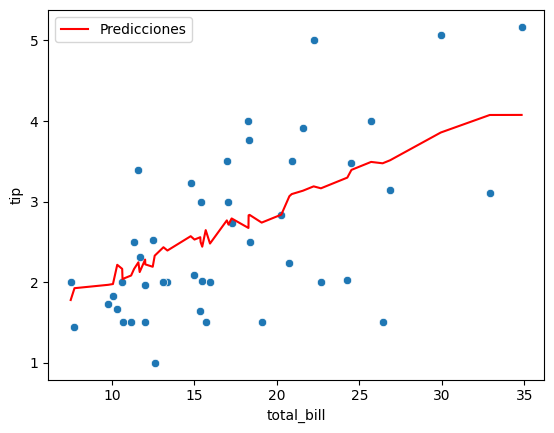

In [40]:
make_prediction(
    model_name="Regresión Múltiple (total_bill, size, datetime  vs tip)",  
    df=df, 
    x_columns=['total_bill', 'size', 'datetime'], 
    y_column='tip', 
    delete_outliers=True
)

### 3.6 Resultados y conclusiones

In [41]:
df_results

,model_name,mae,mse,rmse,score,outlayers_deleted
0,Regresión Simple (total_bill vs tip),0.620858,0.568814,0.754198,0.544938,False
1,Regresión Simple (total_bill vs tip),0.675937,0.669560,0.818266,0.370237,True
2,Regresión Múltiple (total_bill & size vs tip),0.663924,0.648600,0.805357,0.481108,False
3,Regresión Múltiple (total_bill & size vs tip),0.669061,0.657831,0.811068,0.381269,True
4,"Regresión Múltiple (total_bill, size, datetime...",0.663741,0.648327,0.805188,0.481326,False
5,"Regresión Múltiple (total_bill, size, datetime...",0.667882,0.656884,0.810484,0.382160,True


Como se puede apreciar, los mejores resultados que se han obtenido ha sido haciendo una predicción comparando la columna total_bill con la columna tip sin un ajuste por borrar outliers.

Entonces en este caso, utilizaría ese modelo para poder hacer predicciones en base a unos parámetros de entrada.

## 4. Prueba del modelo

In [42]:
custom_data = pd.DataFrame({'total_bill': [23.9, 50, 60, 80, 200]})
y_new = simple_model.predict(custom_data)
custom_data['estimated_tip'] = y_new

custom_data



,total_bill,estimated_tip
0,23.9,3.270390
1,50.0,5.508486
2,60.0,6.365994
3,80.0,8.081010
4,200.0,18.371107


## 5. Exportar el modelo

In [43]:
dump(simple_model, 'model.joblib')

['model.joblib']

## 6. Uso del modelo exportado

In [44]:
exported_model = load('model.joblib')

custom_data = pd.DataFrame({'total_bill': [23.9, 50, 60, 80, 200]})
y_new = exported_model.predict(custom_data)
custom_data['estimated_tip'] = y_new

custom_data


,total_bill,estimated_tip
0,23.9,3.270390
1,50.0,5.508486
2,60.0,6.365994
3,80.0,8.081010
4,200.0,18.371107
